In [23]:
#!/usr/local/lib/anaconda3/bin/python
# -*- coding: utf-8 -*-
import sys
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import pandas as pd
import csv
from scipy import optimize

### experiment design2 (Zupanski et al. 2008)

1.$ dx = 0.05, dt = 0.0125(= 45 sec), \nu = 0.05 $

2.number of points = 81, member = 4, number of observations = 81(all)

3.number of DA cycles = 20, interval between cycles = 15 minutes(= every 20 steps)

4-1.quadratic obs
$ H(x) = x^2 (x \ge 0.5) , -x^2 (x \lt 0.5) $

obs mean = 0.0, obs stdv = 8.0e-2, obs PDF = Gaussian

4-2.cubic obs
$ H(x) = x^3 (x \ge 0.5) , -x^3 (x \lt 0.5) $

obs mean = 0.0, obs stdv = 7.0e-4, obs PDF = Gaussian

5.initial state = begin forecast 2 cycles before TRUE

6.ensemble perturbation = lagged forecast (lag interval = ?)


In [2]:
# BURGERS MODEL
def l_operator(f, u, dx, nu):
# NB u is defined at integral index
# u[i-1/2] = (u[i-1] + u[i]) / 2
# u[i+1/2] = (u[i] + u[i+1]) / 2
# u[i+1/2] - u[i-1/2] = (u[i+1] - u[i-1]) / 2
    l = np.zeros_like(u)
    l[1:-1] = -0.5 * (f[2:] - f[0:-2]) / dx \
        + nu / dx**2 * (u[2:] - 2 * u[1:-1] + u[0:-2])
    return l


def step(u, dx, dt, nu):
    f = 0.5 * u**2
    u1 = u + dt * l_operator(f, u, dx, nu)
    return 0.5 * (u + u1 + dt * l_operator(f, u1, dx, nu))

In [49]:
def golden_section(x0,d0,*args):
    a0=-10
    b0=10
    t = 0.618 #golden_ratio
    a=a0
    b=b0
    c1=(a+b)/2-1
    c2=(a+b)/2+1
    num=0
    #print(num,a,b,c1,c2,abs(b-a))
    for k in range(1000):
        num+=1
        x1 = x0 + c1*d0
        f1 = J(x1,*args)
        x2 = x0 + c2*d0
        f2 = J(x2,*args)
        if(f2>f1):
            a=a
            b=c2
            c2_=c1
            c1_=a+(1-t)*(b-a)
        else:
            a=c1
            b=b
            c1_=c2
            c2_=b-(1-t)*(b-a)
        if(abs(b-a)<0.0001):
            #print(num,"end")
            break
        c1 = min(c1_,c2_)
        c2 = max(c1_,c2_)
        #print(num,a,b,c1,c2,abs(b-a))
    return a

def CG(x0,*args):
    d0 = -jacobi(x0,*args)
    for k in range(1000):
        alpha = golden_section(x0,d0,*args)
        print("step size = {}".format(alpha))
        x = x0 + alpha*d0
        d = jacobi(x,*args)
        nrm = np.sqrt(np.sum(d**2))
        print("|d| = {}".format(nrm))
        if(nrm<1e-7):
            print(k,"end")
            jmin = J(x,*args)
            print("current cost function value = {}".format(jmin))
            break
        p = -d + (np.dot(d.T,d)/np.dot(d0.T,d0))*d0
        x0 = x
        d0 = p
    jmin = J(x,*args)
    print("current cost function value(not converge) = {}".format(jmin))
    return x, jmin

In [6]:
sig = 8.0e-2
p = 10
R = np.eye(p)*sig*sig
R_inv = np.linalg.inv(R)
R_sqrt = np.sqrt(R_inv)
print(R)
print(R_inv)
print(R@R_inv)
print(R_sqrt)

[[0.0064 0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.0064 0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.0064 0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.0064 0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.0064 0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.0064 0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.0064 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.0064 0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.0064 0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0064]]
[[156.25   0.     0.     0.     0.     0.     0.     0.     0.     0.  ]
 [  0.   156.25   0.     0.     0.     0.     0.     0.     0.     0.  ]
 [  0.     0.   156.25   0.     0.     0.     0.     0.     0.     0.  ]
 [  0.     0.     0.   156.25   0.     0.     0.  

In [48]:
### MLEF code
def Analysis(Xfc,Xf,dXf,y,sig,m,N,a,mask,opt,save_hist=False):
    global zetak
    #N = 40
    p = N-a
    #R = np.eye(p)*sig*sig
    #print(np.mean(np.diag(R)))
    I = np.eye(m)
    
    R_sqrt = np.diag(np.ones(p)/sig)
    #R_inv = np.linalg.inv(R)
    R_inv = R_sqrt.T @ R_sqrt
    z = R_sqrt@H_obs(Xf,mask,opt) - R_sqrt@H_obs(Xfc,mask,opt).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    C = z.T@z
    tmp = C[:,:]
    print(np.linalg.cond(tmp))
    #print(C)
    
    la,v = np.linalg.eigh(C)
    #print(v)
    D = np.diag(np.sqrt(1.0/(la+np.ones(m))))
    #print(D)
    #V = np.array(v).reshape(m,m)
    A = v @ D @ v.T #Hessian(J)^(-1/2)=(I+C)^(-1/2)
    
    zeta0 = np.zeros(m)
    args = (Xfc,dXf,A,y,R_sqrt,mask,opt)
    if(save_hist):
        zetak = []
        res = optimize.minimize(J, zeta0, args=args, method='BFGS', jac=jacobi,\
                                options={'gtol':1e-8, 'disp':True}, callback=callback)
        jh = np.zeros(len(zetak))
        gh = np.zeros(len(zetak))
        for i in range(len(zetak)):
            jh[i] = J(zetak[i], *args)
            g = jacobi(zetak[i], *args)
            gh[i] = np.sqrt(np.sum(g**2))
        np.savetxt("jh_{}_MLEF.txt".format(obstype[opt]), jh)
        np.savetxt("gh_{}_MLEF.txt".format(obstype[opt]), gh)
    else:
        res = optimize.minimize(J, zeta0, args=args, method='BFGS', jac=jacobi, options={'gtol':1e-8, 'disp':True})
    #Pa_ = res.hess_inv #(I+C)^(-T/2)?
    zeta = res.x
    jmin = res.fun
    #zeta,jmin = CG(zeta0,*args)
    Xac = Xfc + dXf@A@zeta
    
    Xf = Xac.reshape(-1,1)+dXf
    z_opt = R_sqrt@H_obs(Xf,mask,opt) - R_sqrt@H_obs(Xac,mask,opt).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    C_opt = z_opt.T@z_opt
    
    la,v = np.linalg.eigh(C_opt)
    #print(v)
    D = np.diag(np.sqrt(1.0/(la+np.ones(m))))
    #print(D)
    #V = np.array(v).reshape(m,m)
    A = v @ D @ v.T #(I+C_opt)^(-T/2)
    #print(A)
    
    # Chi^2 test
    # chi^2 = {R^(-1/2)[y-H(x)]}^TG^(-1){R^(-1/2)[y-H(x)]}/N_obs
    # G^(-1) = (I + ZZ^T)^(-1) = I - Z(I+Z^TZ)^(-1)Z^T = I - Z(I+C_opt)^(-1)Z^T
    G_inv = np.eye(p) - z_opt @ v @ np.diag(1.0/(la+np.ones(m))) @ v.T @ z_opt.T
    dep = y - H_obs(Xac,mask,opt)
    innv = R_sqrt@dep.reshape(-1,1)
    chi2 = innv.T @ G_inv @ innv / p
    
    dXa = dXf@A #Pf^(1/2)(I+C_opt)^(-T/2)
    
    Xa = np.zeros((N,m))
    Xa = dXa + Xac.reshape(-1,1)
    Pa = dXa@dXa.T
    
    return Xa,Pa,Xac,jmin,chi2[0]

def J(zeta,*args):
    xb,dXf,A,y,R_sqrt,mask,opt = args
    
    R_inv = R_sqrt.T @ R_sqrt
    B = A.T@A #(I+C)^(-1)
     
    x = xb + dXf@A@zeta
    inv = y - H_obs(x,mask,opt)  
    return (zeta.T@B@zeta + inv.T@R_inv@inv)/2

def jacobi(zeta,*args):
    xb,dXf,A,y,R_sqrt,mask,opt = args
    #B = A.T@A #(I+C)^(-1)
    #R_sqrt = np.sqrt(R_inv)
    
    x = xb + dXf@A@zeta
    z = R_sqrt@H_obs(x.reshape(-1,1)+dXf,mask,opt) - R_sqrt@H_obs(x,mask,opt).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    inv = y - H_obs(x,mask,opt)
    ## modified
    #djo = A.T@z.T@R_sqrt@inv
    djo = z.T@R_sqrt@inv#.reshape(-1,1)
    
    #return B@zeta - djo
    return A@zeta - djo

def callback(xk):
    global zetak
    zetak.append(xk)

In [39]:
### GRAD code
def Analysis_G(Xfc,Xf,dXf,y,sig,m,N,a,mask,opt,save_hist=False):
    global zetak
    #N = 40
    p = N-a
    #R = np.eye(p)*sig*sig
    #print(np.mean(np.diag(R)))
    I = np.eye(m)
    
    R_sqrt = np.diag(np.ones(p)/sig)
    #R_inv = np.linalg.inv(R)
    R_inv = R_sqrt.T @ R_sqrt
    #z = R_sqrt@H_t(Xfc,dXf,mask) #R^(-1/2)HPf^(1/2)
    #z = R_sqrt@H2_t(Xfc,dXf,mask)
    z = R_sqrt@Hobs_t(Xfc,dXf,mask,opt)
    C = z.T@z
    tmp = C[:,:]
    print(np.linalg.cond(tmp))
    #print(C)
    
    la,v = np.linalg.eigh(C)
    #print(v)
    D = np.diag(np.sqrt(1.0/(la+np.ones(m))))
    #print(D)
    #V = np.array(v).reshape(m,m)
    A = v @ D @ v.T #(I+C)^(-T/2)
    
    zeta0 = np.zeros(m)
    args = (Xfc,dXf,A,y,R_sqrt,mask,opt)
    if(save_hist):
        zetak = []
        res = optimize.minimize(J_G, zeta0, args=args, method='BFGS', jac=jacobi_G, \
                                options={'gtol':1e-8, 'disp':True}, callback=callback)
        jh = np.zeros(len(zetak))
        gh = np.zeros(len(zetak))
        for i in range(len(zetak)):
            jh[i] = J_G(zetak[i], *args)
            g = jacobi_G(zetak[i], *args)
            gh[i] = np.sqrt(np.sum(g**2))
        np.savetxt("jh_{}_GRAD.txt".format(obstype[opt]), jh)
        np.savetxt("gh_{}_GRAD.txt".format(obstype[opt]), gh)
    else:
        res = optimize.minimize(J_G, zeta0, args=args, method='BFGS', jac=jacobi_G, options={'gtol':1e-8, 'disp':True})
    zeta = res.x
    jmin = res.fun
    #Pa_ = res.hess_inv #(I+C)^(-T/2)?
    #zeta,jmin = CG(zeta0,*args)
    Xac = Xfc + dXf@A@zeta
    
    #Xf = Xac.reshape(-1,1)+dXf
    #z_opt = R_sqrt@H_t(Xac,dXf,mask) #R^(-1/2)HPf^(1/2)
    #z_opt = R_sqrt@H2_t(Xac,dXf,mask)
    z_opt = R_sqrt@Hobs_t(Xac,dXf,mask,opt)
    C_opt = z_opt.T@z_opt
    
    la,v = np.linalg.eigh(C_opt)
    #print(v)
    D = np.diag(np.sqrt(1.0/(la+np.ones(m))))
    #print(D)
    #V = np.array(v).reshape(m,m)
    A = v @ D @ v.T #(I+C_opt)^(-T/2)
    #print(A)
    
    # Chi^2 test
    # chi^2 = {R^(-1/2)[y-H(x)]}^TG^(-1){R^(-1/2)[y-H(x)]}/N_obs
    # G^(-1) = (I + ZZ^T)^(-1) = I - Z(I+Z^TZ)^(-1)Z^T = I - Z(I+C_opt)^(-1)Z^T
    G_inv = np.eye(p) - z_opt @ v @ np.diag(1.0/(la+np.ones(m))) @ v.T @ z_opt.T
    dep = y - H_obs(Xac,mask,opt)
    innv = R_sqrt@dep.reshape(-1,1)
    chi2 = innv.T @ G_inv @ innv / p
    
    dXa = dXf@A #Pf^(1/2)(I+C_opt)^(-T/2)
    
    Xa = np.zeros((N,m))
    Xa = dXa + Xac.reshape(-1,1)
    Pa = dXa@dXa.T
    
    return Xa,Pa,Xac,jmin,chi2[0]

def J_G(zeta,*args):
    xb,dXf,A,y,R_sqrt,mask,opt = args
    R_inv = R_sqrt.T @ R_sqrt
    B = A.T@A #(I+C)^(-1)
     
    x = xb + dXf@A@zeta
    inv = y - H_obs(x,mask,opt)   
    return (zeta.T@B@zeta + inv.T@R_inv@inv)/2

def jacobi_G(zeta,*args):
    xb,dXf,A,y,R_sqrt,mask,opt = args
    #B = A.T@A #(I+C)^(-1)
    #R_sqrt = np.sqrt(R_inv)
    
    x = xb + dXf@A@zeta
    #z = R_sqrt@H_obs(x.reshape(-1,1)+dXf,mask) - R_sqrt@H_obs(x,mask).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    z = R_sqrt@Hobs_t(x,dXf,mask,opt) #R^(-1/2)(dH/dx)Pf^(1/2)
    inv = y - H_obs(x,mask,opt)
    ##modified
    #djo = A.T@z.T@R_sqrt@inv
    djo = z.T@R_sqrt@inv#.reshape(-1,1)
    #return B@zeta - djo
    return A@zeta - djo

def callback(xk):
    global zetak
    zetak.append(xk)

In [5]:
def H_obs(x,mask,opt):
    
    xo = np.delete(x,mask,axis=0)
    sign = np.ones(xo.shape)
    sign[xo<0.5] = -1
    if(opt==0):
    ## y = x
        y = xo
    elif (opt==1):
    ## y = x^2
        y = xo**2
    elif (opt==2):
    ## y = x^3
        y = xo**3
    elif (opt==3):
    ## y = x^2 or -x^2
        y = sign * (xo**2)
    elif (opt==4):
    ## y = x^3 or -x^3
        y = sign * (xo**3)
        
    return y

def Hobs_t(x,dx,mask,opt):
    xo = np.delete(x,mask,axis=0)
    dxo = np.delete(dx,mask,axis=0)
    sign = np.ones(xo.shape)
    sign[xo<0.5] = -1
    if(opt==0):
    ## y = x
        y = dxo
    elif (opt==1):
    ## y = x^2
        y = 2.0*xo.reshape(-1,1)*dxo
    elif (opt==2):
    ## y = x^3
        y = 3.0*(xo*xo).reshape(-1,1)*dxo
    elif (opt==3):
    ## y = x^2 or -x^2
        y = 2.0*(sign*xo).reshape(-1,1)*dxo
    elif (opt==4):
    ## y = x^3 or -x^3
        y = 3.0*(sign*xo*xo).reshape(-1,1)*dxo
        
    return y

In [123]:
init_obs = False
xi = np.array([0.4])
p = np.array([1.0])
mask = np.random.choice(1,0,replace=False)
print(H_obs(xi+p,mask,4)-H_obs(xi,mask,4))
print(Hobs_t(xi,p,mask,4))
print(1.4**3+0.4**3)
print(init_obs)

[2.808]
[[-0.48]]
2.8079999999999994
False


In [6]:
def initialize(opt):
    global u0, x, jmax, xmax, dx, dt, nu, dt_sec, obs_m, obs_s, obs_opt, obstype
    
    jmax = 81
    xmax = 2.0
    dx = 0.05
    dt = 0.0125
    dt_sec = dt*3600.0
    nu = 0.05
    x = np.arange(jmax)*dx - xmax
    u0 = np.zeros(jmax)
    u0[0] = 1.0
    dum = np.zeros(jmax)
    obs_opt = opt
    
    obs_m = 0.0
    if(opt==0): # y=x
        obs_s = 1.0e-1
    elif(opt==1 or opt==3): # y=x^2
        obs_s = 8.0e-2
    elif(opt==2 or opt==4): # y=x^3
        obs_s = 7.0e-4
    
    # initial state
    for k in range(40):
        dum = step(u0, dx, dt, nu)
        u0 = dum[:]
    plt.plot(x,u0)
    plt.title("initial state")
    plt.show()
    print("nx={} nu={} dx={:7.3e} dt={:7.3e} dt_sec={:7.3e}".format(jmax, nu, dx, dt, dt_sec))
    obstype = ['unit','quad','cubic','quad_nonlinear','cubic_nonlinear']
    print(obstype[obs_opt])

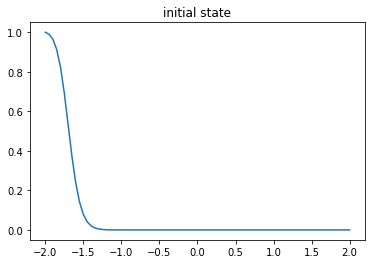

nx=81 nu=0.05 dx=5.000e-02 dt=1.250e-02 dt_sec=4.500e+01
cubic_nonlinear
Number of DA cycles = 20cycles, cycle interval = 15.0min., each cycle steps = 20steps
Number of observations = 81, observation option = 4
fcst length = 400, incr_dt = 900.0sec.
[1.00000000e+00 9.89551766e-01 9.64332152e-01 9.12943022e-01
 8.23325101e-01 6.91853561e-01 5.32260231e-01 3.72328806e-01
 2.38035879e-01 1.40890357e-01 7.83472428e-02 4.14353201e-02
 2.10152930e-02 1.02718782e-02 4.85097001e-03 2.21608022e-03
 9.79758666e-04 4.19259099e-04 1.73649699e-04 6.96116177e-05
 2.70085830e-05 1.01424872e-05 3.68666563e-06 1.29719399e-06
 4.41876940e-07 1.45737479e-07 4.65441501e-08 1.43957113e-08
 4.31244332e-09 1.25135399e-09 3.51756866e-10 9.57951224e-11
 2.52759881e-11 6.46181058e-12 1.60062718e-12 3.84162579e-13
 8.93341931e-14 2.01268732e-14 4.39296400e-15 9.28788040e-16
 1.90193457e-16 3.77158299e-17 7.24129363e-18 1.34577859e-18
 2.42036625e-19 4.21121240e-20 7.08602738e-21 1.15265789e-21
 1.81180797e-22 2.

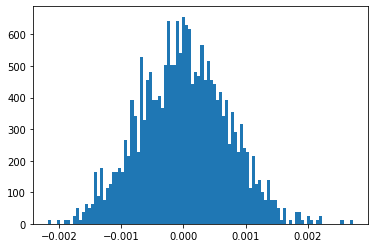

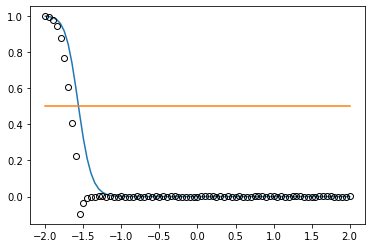

obs mean=2.0770268256841497e-05, obs stdv=5.402132122960671e-07


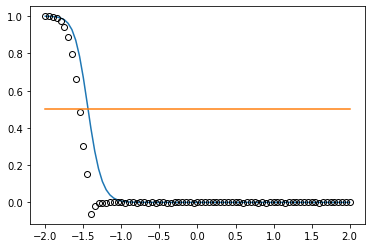

obs mean=3.8881514652004115e-05, obs stdv=4.196962949060306e-07


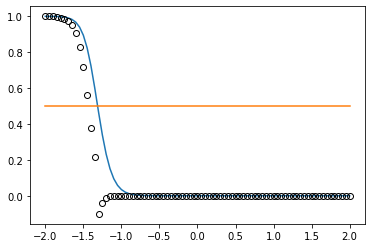

obs mean=-9.912046505134728e-05, obs stdv=4.82611739889041e-07


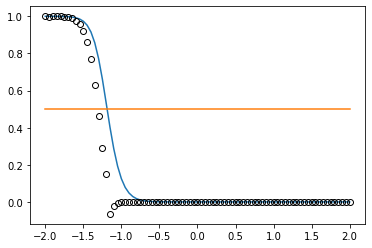

obs mean=-3.8757437537781466e-05, obs stdv=4.00360687478365e-07


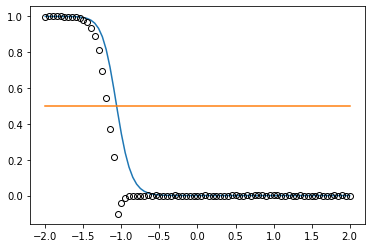

obs mean=-6.302599643431505e-05, obs stdv=4.4042452729757007e-07


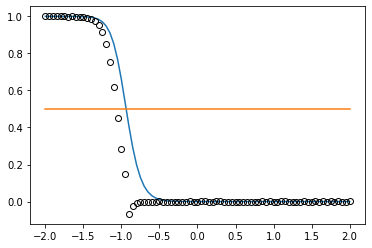

obs mean=-9.412629421922313e-06, obs stdv=3.9642985912531384e-07


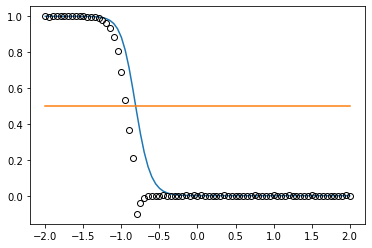

obs mean=0.00013396824659912379, obs stdv=5.21324350535523e-07


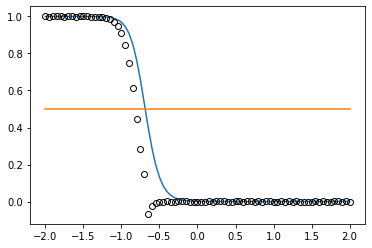

obs mean=8.227541460146546e-05, obs stdv=4.5812863162775697e-07


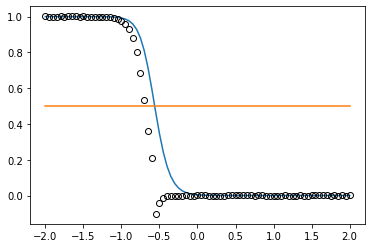

obs mean=6.580128592133102e-06, obs stdv=4.081644210052725e-07


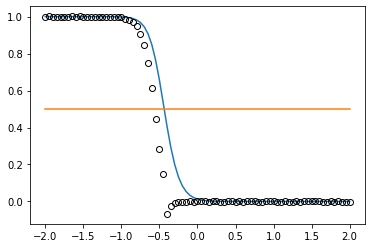

obs mean=1.7854002576399396e-05, obs stdv=5.637067619597897e-07


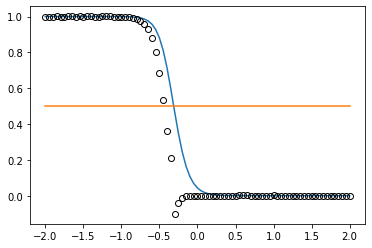

obs mean=-3.5794747885662346e-05, obs stdv=5.936713826161494e-07


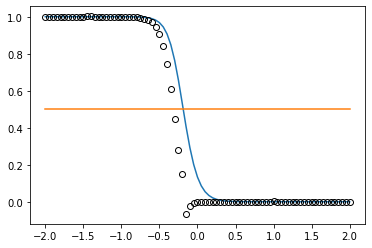

obs mean=-1.7309316490465647e-05, obs stdv=5.020240231750123e-07


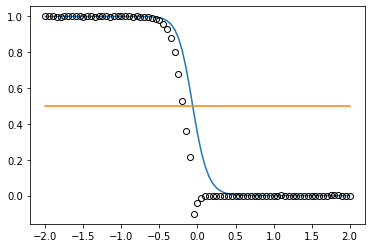

obs mean=3.219643030511795e-05, obs stdv=4.934625209013399e-07


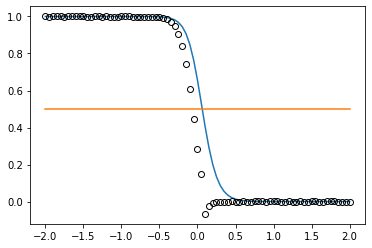

obs mean=5.1230436037438086e-05, obs stdv=4.966966754279656e-07


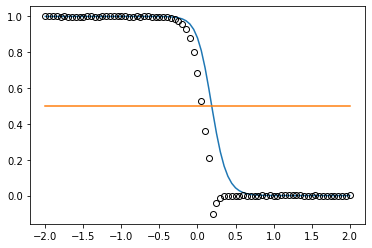

obs mean=-5.0155620297062674e-05, obs stdv=4.578966860997292e-07


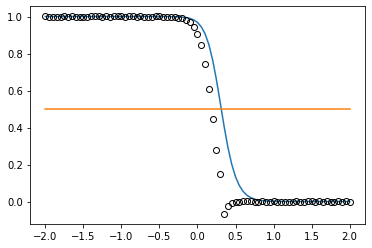

obs mean=-4.238973944583651e-05, obs stdv=5.638099671139668e-07


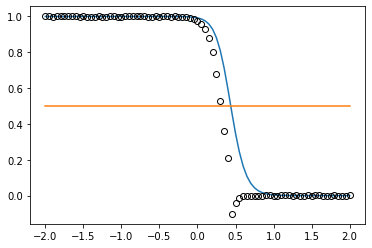

obs mean=7.66619843749807e-05, obs stdv=6.250775808372778e-07


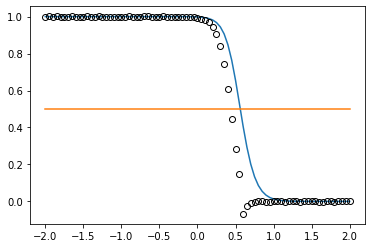

obs mean=-5.086677369751259e-06, obs stdv=5.505793809351831e-07


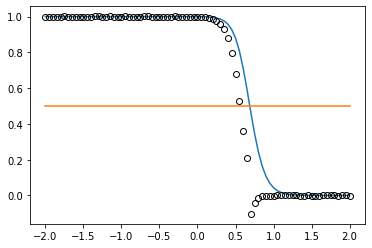

obs mean=4.418855890650271e-05, obs stdv=5.564819789718625e-07


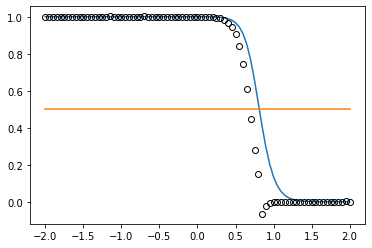

obs mean=4.303856891914841e-05, obs stdv=5.576468466091696e-07


In [25]:
### true state and obs
initialize(opt=4)
N_cycles = 20
cycle_int = 15.0 #minutes
N_steps = int(cycle_int * 60. / dt_sec)
N_obs = jmax
print("Number of DA cycles = {}cycles, cycle interval = {}min., each cycle steps = {}steps"
      .format(N_cycles, cycle_int, N_steps))
print("Number of observations = {}, observation option = {}".format(N_obs, obs_opt))

yo = np.zeros((N_cycles,N_obs)) # observation
mask = np.random.choice(jmax,jmax-N_obs,replace=False) # obsmiss

## true
fcst_length = N_steps * N_cycles
incr_dt = cycle_int * 60.
print("fcst length = {}, incr_dt = {}sec.".format(fcst_length, incr_dt))
ut = np.zeros((fcst_length+1,jmax))
# initialize
ut[0] = u0[:]

#plt.plot(x,ut[0])
print(ut[0])
line = np.ones(x.size)*0.5
i = 0
for k in range(1,fcst_length+1):
    ut[k] = step(ut[k-1], dx, dt, nu)
    if (k%N_steps==0):
        yo[i] = H_obs(ut[k],mask,obs_opt)
        i += 1
        print("cycle{}".format(int(k/N_steps)))
        #print(ut[k])
#plt.title("true state")
#plt.show()

## observation
#obs_m = obs_m3
#obs_s = obs_s3
print(obs_m, obs_s)
#err = [random.normalvariate(obs_m, obs_s) for k in range(yo.size)]
#oberr = np.array(err).reshape(yo.shape)
oberr = random.normal(obs_m, scale=obs_s, size=yo.size)
plt.hist(oberr,bins=100,density=True)
plt.show()
yo += oberr.reshape(yo.shape)
for k in range(N_cycles):
    d = yo[k] - H_obs(ut[int((k+1)*N_steps)],mask,obs_opt)
    plt.plot(x,ut[int((k+1)*N_steps)])
    plt.plot(x,yo[k],"ko",markerfacecolor="none")
    plt.plot(x,line)
    plt.show()
        
    #print(d)
    print("obs mean={}, obs stdv={}".format(np.mean(d), np.mean((d - np.mean(d))**2)))

fcst length = 440, incr_dt = 900.0sec.
cycle1
[1.00000000e+00 9.99908672e-01 9.99678314e-01 9.99157250e-01
 9.98051136e-01 9.95805034e-01 9.91400100e-01 9.83026413e-01
 9.67619580e-01 9.40383346e-01 8.94776989e-01 8.23951650e-01
 7.24436924e-01 6.00695742e-01 4.66282606e-01 3.38772611e-01
 2.31882720e-01 1.51101835e-01 9.47838206e-02 5.77806019e-02
 3.44713147e-02 2.02200479e-02 1.16944707e-02 6.67926742e-03
 3.77007931e-03 2.10356506e-03 1.16020226e-03 6.32422591e-04
 3.40619995e-04 1.81219503e-04 9.52129056e-05 4.93894301e-05
 2.52883700e-05 1.27781734e-05 6.37091153e-06 3.13367352e-06
 1.52044191e-06 7.27618146e-07 3.43413036e-07 1.59837608e-07
 7.33611398e-08 3.32016670e-08 1.48165608e-08 6.51958794e-09
 2.82861351e-09 1.21005966e-09 5.10412945e-10 2.12286778e-10
 8.70597634e-11 3.52057942e-11 1.40385885e-11 5.52023136e-12
 2.14056655e-12 8.18562506e-13 3.08703424e-13 1.14818792e-13
 4.21194169e-14 1.52393288e-14 5.43850998e-15 1.91443770e-15
 6.64762339e-16 2.27704719e-16 7.694396

cycle12
[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.99999999e-01 9.99999999e-01
 9.99999997e-01 9.99999994e-01 9.99999989e-01 9.99999979e-01
 9.99999961e-01 9.99999926e-01 9.99999862e-01 9.99999744e-01
 9.99999528e-01 9.99999133e-01 9.99998414e-01 9.99997110e-01
 9.99994750e-01 9.99990488e-01 9.99982808e-01 9.99968994e-01
 9.99944184e-01 9.99899685e-01 9.99819967e-01 9.99677309e-01
 9.99422283e-01 9.98966884e-01 9.98154761e-01 9.96709155e-01
 9.94143197e-01 9.89609660e-01 9.81662189e-01 9.67913584e-01
 9.44651646e-01 9.06683206e-01 8.48033144e-01 7.64252988e-01
 6.56079518e-01 5.31949583e-01 4.06182783e-01 2.93109850e-01
 2.01580497e-01 1.33528506e-01 8.60720832e-02 5.44497545e-02
 3.40182740e-02 2.10816865e-02 1.29963975e-02 7.98471147e-03
 4.89446688e-03 2.99541406e-03 1.83098274e-03 1.11809651e-03
 6.82156212e-04 4.15822498e-04 2.53245258e-04 1.54084862e-04
 9.36549970e-05 5.68610618e-05 3.44800743e-05 2.08806263e-05
 1.26267442e-05 

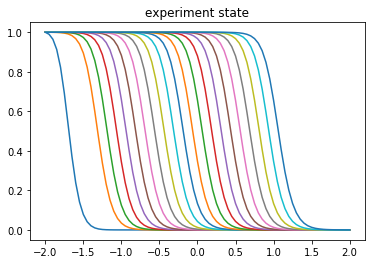

rmse no-obs
[0.16788967 0.16248934 0.15956811 0.15784898 0.15678619 0.15610811
 0.1556661  0.15537353 0.15517768 0.15504544 0.15495555 0.15489411
 0.15485193 0.15482286 0.15480277 0.15478885 0.15477917 0.15477244
 0.15476774 0.15476446 0.15476215]


In [8]:
### No-observation experiment
N_cycle_shift = 2 #initial condition lag
fcst_length = N_steps * ( N_cycles + N_cycle_shift )
incr_dt = cycle_int * 60.

print("fcst length = {}, incr_dt = {}sec.".format(fcst_length, incr_dt))
un = np.zeros((fcst_length+1,jmax))
# initialize
un[0] = u0[:]
plt.plot(x,un[0])
for k in range(1,fcst_length+1):
    un[k] = step(un[k-1], dx, dt, nu)
    if (k/N_steps>N_cycle_shift and k%N_steps==0):
        plt.plot(x,un[k])
        print("cycle{}".format(int(k/N_steps-N_cycle_shift)))
        print(un[k])
plt.title("experiment state")
plt.show()

rmsen = np.zeros(N_cycles+1)
for i in range(N_cycles+1):
    ind_n = (i+N_cycle_shift)*N_steps
    ind_t = i*N_steps
    rmsen[i] = np.mean((un[ind_n]-ut[ind_t])**2)
rmsen = np.sqrt(rmsen)
print("rmse no-obs")
print(rmsen)

In [9]:
### ensemble initialize
def init_ens(lag):
    global mem, uc0, ue0, sqrtPa0, ispr
    mem = 4 # ensemble size
    #lag = 15#int(N_steps/2)

    ## control
    t_cntrl = N_cycle_shift * N_steps
    uc0 = np.zeros(jmax)
    uc0 = un[t_cntrl,:]
    #plt.plot(x,uc0)
    ue0 = np.zeros((jmax,mem))
    for imem in range(int(mem/2)):
        t_mem = t_cntrl - lag*(imem+1)
        ue0[:,2*imem] = un[t_mem,:]
        t_mem = t_cntrl + lag*(imem+1)
        ue0[:,2*imem+1] = un[t_mem,:]
    #for imem in range(mem):
    #    plt.plot(x,ue0[:,imem])
    #plt.title("ensemble state")
    #plt.show()
    sqrtPa0 = (ue0 - uc0.reshape(-1,1))#/np.sqrt(2.0*(mem-1))
    P0 = sqrtPa0@sqrtPa0.T/np.sqrt(mem-1)
    ispr = np.mean(np.diag(P0))
    print("initial ensemble spread = {}".format(ispr))
    print("ensemble initialized")
    #print(sqrtPa0)

In [50]:
### assimilation
fcst_length = N_cycles * N_steps
obsmiss = jmax - N_obs
print("fcst length = {}, incr_dt = {}sec., obs miss = {}".format(fcst_length, incr_dt, obsmiss))

lag = 10
## MLEF
##initialize
init_ens(lag)
ua = np.zeros((fcst_length+1,jmax)) # analysis, control
uf = np.zeros((fcst_length+1,jmax)) # forecast, control
ue = np.zeros((jmax,mem)) # ensemble(analysis)
uef = np.zeros((jmax,mem)) # ensemble(forecast)
ua[0] = uc0[:]
uf[0] = uc0[:]
ue = ue0[:,:]
trPa = []
Jmin_m = []
Chi_m = []
P0 = sqrtPa0@sqrtPa0.T
trPa.append(np.mean(np.diag(P0)))
for k in range(1,fcst_length+1):
    # forecast
    uf[k] = step(ua[k-1], dx, dt, nu)
    for imem in range(mem):
        uef[:,imem] = step(ue[:,imem], dx, dt, nu)
    sqrtPf = np.zeros(uef.shape)
    sqrtPf = uef - uf[k].reshape(-1,1)#/np.sqrt(mem-1)
    #sqrtPf = (uef - uf[k].reshape(-1,1))/np.sqrt(2.0*(mem-1))
    if(k%N_steps==0):
    # analysis
        k_obs = int(k/N_steps) - 1
        print("cycle"+str(k_obs))
        mask = np.random.choice(jmax,obsmiss,replace=False)
        if(k_obs==0):
            (ue, Pa, ua[k], jmin, chi2) = Analysis(uf[k], uef, sqrtPf, yo[k_obs], obs_s, mem, jmax, obsmiss, mask, obs_opt,\
                                                  save_hist=True)
        else:
            (ue, Pa, ua[k], jmin, chi2) = Analysis(uf[k], uef, sqrtPf, yo[k_obs], obs_s, mem, jmax, obsmiss, mask, obs_opt)
        trPa.append(np.mean(np.diag(Pa)))
        Jmin_m.append(jmin)
        Chi_m.append(chi2)
    else:
        ua[k] = uf[k]
        ue = uef[:,:]

rmsea = np.zeros(N_cycles)
for i in range(1,N_cycles+1):
    ind_a = i*N_steps
    ind_t = i*N_steps
    rmsea[i-1] = np.mean((ua[ind_a]-ut[ind_t])**2)
rmsea = np.sqrt(rmsea)

fig = plt.figure()
ax = []
for i in range(1,5):
    ind_a = i*N_steps
    ind_t = i*N_steps
    ax.append(fig.add_subplot(2, 2, i, title="cycle"+str(i)))
    ax[i-1].plot(x, ua[ind_a]-ut[ind_t],label="MLEF")


## GRAD
##initialize
init_ens(lag)
ua = np.zeros((fcst_length+1,jmax)) # analysis, control
uf = np.zeros((fcst_length+1,jmax)) # forecast, control
ue = np.zeros((jmax,mem)) # ensemble(analysis)
uef = np.zeros((jmax,mem)) # ensemble(forecast)
ua[0] = uc0[:]
uf[0] = uc0[:]
ue = ue0[:,:]
trPa = []
Jmin_g = []
Chi_g = []
P0 = sqrtPa0@sqrtPa0.T
trPa.append(np.mean(np.diag(P0)))
for k in range(1,fcst_length+1):
    # forecast
    uf[k] = step(ua[k-1], dx, dt, nu)
    for imem in range(mem):
        uef[:,imem] = step(ue[:,imem], dx, dt, nu)
    sqrtPf = np.zeros(uef.shape)
    sqrtPf = (uef - uf[k].reshape(-1,1))#/np.sqrt(mem-1)
    #sqrtPf = (uef - uf[k].reshape(-1,1))/np.sqrt(2.0*(mem-1))
    if(k%N_steps==0):
    # analysis
        k_obs = int(k/N_steps) - 1
        print("cycle"+str(k_obs))
        mask = np.random.choice(jmax,obsmiss,replace=False)
        if(k_obs==0):
            (ue, Pa, ua[k], jmin, chi2) = Analysis_G(uf[k], uef, sqrtPf, yo[k_obs], obs_s, mem, jmax, obsmiss, mask, obs_opt,\
                                                    save_hist=True)
        else:
            (ue, Pa, ua[k], jmin, chi2) = Analysis_G(uf[k], uef, sqrtPf, yo[k_obs], obs_s, mem, jmax, obsmiss, mask, obs_opt)
        trPa.append(np.mean(np.diag(Pa)))
        Jmin_g.append(jmin)
        Chi_g.append(chi2)
    else:
        ua[k] = uf[k]
        ue = uef[:,:]
rmseg = np.zeros(N_cycles)
for i in range(1,N_cycles+1):
    ind_a = i*N_steps
    ind_t = i*N_steps
    rmseg[i-1] = np.mean((ua[ind_a]-ut[ind_t])**2)
rmseg = np.sqrt(rmseg)

for i in range(1,5):
    ind_a = i*N_steps
    ind_t = i*N_steps
    ax[i-1].plot(x, ua[ind_a]-ut[ind_t],label="GRAD")
    
print("rmse MLEF")
print(rmsea)

print("rmse GRAD")
print(rmseg)

plt.legend()
plt.savefig("anl_err_"+obstype[obs_opt]+".png")
plt.show()

print(Chi_m)
print(Chi_g)
#print("error covariance")
#print(trPa)

fcst length = 400, incr_dt = 900.0sec., obs miss = 0
initial ensemble spread = 0.01038567344451425
ensemble initialized
cycle0
125.50067118235117
step size = 0.0010784365754779048
|d| = 119616.09846962822
step size = 0.0033371839513502374
|d| = 127143.38122242398
step size = -0.006704877561512257
|d| = 382013.1573311716
step size = 0.00023496674019064155
|d| = 255674.0121163707
step size = 0.0007803111982043423
|d| = 111741.91146480563
step size = 5.979169643636474e-05
|d| = 106935.79981857956
step size = -2.442773666910291e-05
|d| = 109198.98052645609
step size = -2.984819349467299e-06
|d| = 109469.19091092475
step size = -2.984819349467299e-06
|d| = 109743.5801703904
step size = -2.984819349467299e-06
|d| = 110017.73364039205
step size = -2.984819349467299e-06
|d| = 110293.40539923376
step size = -2.984819349467299e-06
|d| = 110569.95309433107
step size = -2.984819349467299e-06
|d| = 110847.63811524102
step size = -2.984819349467299e-06
|d| = 111126.37053938306
step size = -2.9848193

step size = -2.984819349467299e-06
|d| = 112359.21062846352
step size = 5.979169643636474e-05
|d| = 106743.44718556173
step size = -2.442773666910291e-05
|d| = 108861.22594051853
step size = -2.442773666910291e-05
|d| = 111122.55650983572
step size = -2.984819349467299e-06
|d| = 111402.67974962034
step size = -2.984819349467299e-06
|d| = 111683.34912298135
step size = -2.984819349467299e-06
|d| = 111965.30616635259
step size = -2.984819349467299e-06
|d| = 112248.27975557408
step size = 5.979169643636474e-05
|d| = 106640.90661820328
step size = -2.442773666910291e-05
|d| = 108755.47196218272
step size = -2.442773666910291e-05
|d| = 111013.35432623097
step size = -2.984819349467299e-06
|d| = 111293.04753391609
step size = -2.984819349467299e-06
|d| = 111573.2870517322
step size = -2.984819349467299e-06
|d| = 111854.81158091828
step size = -2.984819349467299e-06
|d| = 112137.35099608752
step size = -2.984819349467299e-06
|d| = 112421.01812328896
step size = 5.979169643636474e-05
|d| = 106

step size = -2.984819349467299e-06
|d| = 112402.38795342474
step size = -2.984819349467299e-06
|d| = 112687.05587557105
step size = -2.984819349467299e-06
|d| = 112972.75309655677
step size = -2.984819349467299e-06
|d| = 113259.5942164034
step size = 5.979169643636474e-05
|d| = 107576.57038431385
step size = -2.442773666910291e-05
|d| = 109719.07186959301
step size = -2.442773666910291e-05
|d| = 112007.35976500338
step size = -2.984819349467299e-06
|d| = 112290.83471799214
step size = -2.984819349467299e-06
|d| = 112574.86320307342
step size = -2.984819349467299e-06
|d| = 112860.19913862992
step size = -2.984819349467299e-06
|d| = 113146.56716007902
step size = -2.984819349467299e-06
|d| = 113434.08242872305
step size = 5.979169643636474e-05
|d| = 107737.71139273742
step size = -2.442773666910291e-05
|d| = 109885.12269410912
step size = -2.442773666910291e-05
|d| = 112178.75925337533
step size = -2.984819349467299e-06
|d| = 112462.89848724488
step size = -2.984819349467299e-06
|d| = 11

step size = -2.442773666910291e-05
|d| = 112998.73771828003
step size = -2.984819349467299e-06
|d| = 113285.99880632355
step size = -2.984819349467299e-06
|d| = 113573.82158595836
step size = -2.984819349467299e-06
|d| = 113862.97408611343
step size = -2.984819349467299e-06
|d| = 114153.17613034356
step size = -2.984819349467299e-06
|d| = 114444.54505474218
step size = 5.979169643636474e-05
|d| = 108672.01379642374
step size = -2.442773666910291e-05
|d| = 110847.40897128763
step size = -2.442773666910291e-05
|d| = 113171.5656120922
step size = -2.984819349467299e-06
|d| = 113459.4990749313
step size = -2.984819349467299e-06
|d| = 113747.99550480503
step size = -2.984819349467299e-06
|d| = 114037.82548820817
step size = -2.984819349467299e-06
|d| = 114328.70799146016
step size = 5.979169643636474e-05
|d| = 108564.99806902725
step size = -2.442773666910291e-05
|d| = 110737.0196678812
step size = -2.442773666910291e-05
|d| = 113057.55267544396
step size = -2.984819349467299e-06
|d| = 1133

step size = -2.984819349467299e-06
|d| = 115978.92479005692
step size = -2.984819349467299e-06
|d| = 116277.31249553092
step size = 5.979169643636474e-05
|d| = 110366.11879118813
step size = -2.442773666910291e-05
|d| = 112592.42117601288
step size = -2.442773666910291e-05
|d| = 114972.13686262438
step size = -2.984819349467299e-06
|d| = 115266.97917958927
step size = -2.984819349467299e-06
|d| = 115562.399754293
step size = -2.984819349467299e-06
|d| = 115859.19504340309
step size = -2.984819349467299e-06
|d| = 116157.07516786836
step size = -2.984819349467299e-06
|d| = 116456.16184793203
step size = 5.979169643636474e-05
|d| = 110531.13380139234
step size = -2.442773666910291e-05
|d| = 112762.51756153286
step size = -2.442773666910291e-05
|d| = 115147.77532295311
step size = -2.984819349467299e-06
|d| = 115443.30615615178
step size = -2.984819349467299e-06
|d| = 115739.41657675216
step size = -2.984819349467299e-06
|d| = 116036.90568133182
step size = -2.984819349467299e-06
|d| = 116

step size = -2.984819349467299e-06
|d| = 116973.64326705906
step size = -2.984819349467299e-06
|d| = 117275.88208089843
step size = 5.979169643636474e-05
|d| = 111288.60755644999
step size = -2.442773666910291e-05
|d| = 113542.82334864966
step size = -2.442773666910291e-05
|d| = 115953.01824765887
step size = -2.984819349467299e-06
|d| = 116251.65098397783
step size = -2.984819349467299e-06
|d| = 116550.87037582239
step size = -2.984819349467299e-06
|d| = 116851.48717874245
step size = -2.984819349467299e-06
|d| = 117153.20662913313
step size = -2.984819349467299e-06
|d| = 117456.1526537941
step size = 5.979169643636474e-05
|d| = 111454.88224128875
step size = -2.442773666910291e-05
|d| = 113714.23619568604
step size = -2.442773666910291e-05
|d| = 116130.0372828378
step size = -2.984819349467299e-06
|d| = 116429.36657223427
step size = -2.984819349467299e-06
|d| = 116729.28387419217
step size = -2.984819349467299e-06
|d| = 117030.60262550965
step size = -2.984819349467299e-06
|d| = 117

step size = 0.8283562271625485
|d| = 388.9784820574322
step size = 0.024269643110707305
|d| = 383.4162803315512
step size = -0.3718545271954627
|d| = 19391.01155347991
step size = -6.567726909747443e-05
|d| = 1070.8176037424762
step size = 0.05457849205572085
|d| = 19415.952162705158
step size = -6.567726909747443e-05
|d| = 466.11150565801523
step size = 0.0481968455924472
|d| = 19419.64665136073
step size = -6.567726909747443e-05
|d| = 956.8462384098157
step size = 0.05482717742813312
|d| = 19411.50666329409
step size = -6.567726909747443e-05
|d| = 503.2971473013534
step size = 0.05012255015753936
|d| = 19423.607284878697
step size = -6.567726909747443e-05
|d| = 883.1809513907409
step size = 0.05499668491809447
|d| = 19420.382587616747
step size = -6.567726909747443e-05
|d| = 532.4721617934294
step size = 0.05147570157004752
|d| = 19433.297524616108
step size = -6.567726909747443e-05
|d| = 832.8344177122884
step size = 0.055113137042425334
|d| = 19423.948313300603
step size = -6.56772

step size = -6.567726909747443e-05
|d| = 648.1310686081773
step size = 0.06362918550246495
|d| = 19554.673912774502
step size = -6.567726909747443e-05
|d| = 595.3862697830098
step size = 0.06403592416606564
|d| = 19557.164521491024
step size = -6.567726909747443e-05
|d| = 649.3713690760393
step size = 0.06390294506176465
|d| = 19556.4685294244
step size = -6.567726909747443e-05
|d| = 591.3882191629037
step size = 0.06436614776517072
|d| = 19558.8501875419
step size = -6.567726909747443e-05
|d| = 651.0793171697882
step size = 0.06413840046452418
|d| = 19551.09008306288
step size = -6.567726909747443e-05
|d| = 586.868452019038
step size = 0.0647216163683199
|d| = 19563.389884884302
step size = -6.567726909747443e-05
|d| = 653.48649783651
step size = 0.06446316613034779
|d| = 19564.565083477224
step size = -6.567726909747443e-05
|d| = 581.8914778976724
step size = 0.06504269940532745
|d| = 19559.720273735125
step size = -6.567726909747443e-05
|d| = 656.3354050866939
step size = 0.06470418

step size = 0.03867220038996688
|d| = 19332.076486238275
step size = -6.567726909747443e-05
|d| = 786.6009824231071
step size = 0.038774749419061796
|d| = 19336.597105084962
step size = -6.567726909747443e-05
|d| = 785.748571252983
step size = 0.03886521797944351
|d| = 19338.538466358936
step size = -6.567726909747443e-05
|d| = 784.9307528435825
step size = 0.03896776700853843
|d| = 19343.019437746283
step size = -6.567726909747443e-05
|d| = 784.08756388199
step size = 0.03904320237480765
|d| = 19341.288785685898
step size = -6.567726909747443e-05
|d| = 783.2764129527067
step size = 0.039165286480756976
|d| = 19350.208777929158
step size = -6.567726909747443e-05
|d| = 782.421608424613
step size = 0.03926783550985189
|d| = 19354.80093328009
step size = -6.567726909747443e-05
|d| = 781.6055146708359
step size = 0.03933122342104001
|d| = 19349.941327807872
step size = -6.567726909747443e-05
|d| = 780.7893758492573
step size = 0.03941703327862691
|d| = 19350.30179751454
step size = -6.5677

step size = 0.045790740549810444
|d| = 19453.535146535763
step size = -6.567726909747443e-05
|d| = 728.1697893220246
step size = 0.04596134188179292
|d| = 19469.14405642645
step size = -6.567726909747443e-05
|d| = 727.4235782525592
step size = 0.04601689997636496
|d| = 19459.62453825465
step size = -6.567726909747443e-05
|d| = 726.619969482564
step size = 0.046106781919939624
|d| = 19457.80419804953
step size = -6.567726909747443e-05
|d| = 725.8638547783336
step size = 0.046263611580333215
|d| = 19470.06808736174
step size = -6.567726909747443e-05
|d| = 725.0980965749848
step size = 0.0463718907309908
|d| = 19471.849239119038
step size = -6.567726909747443e-05
|d| = 724.3253813192385
step size = 0.046480191428384
|d| = 19473.627707924363
step size = -6.567726909747443e-05
|d| = 723.5574546720801
step size = 0.04656276329537169
|d| = 19469.82027451359
step size = -6.567726909747443e-05
|d| = 722.7784179335853
step size = 0.046683432680589575
|d| = 19474.179791051905
step size = -6.56772

C:\Users\kendo\anaconda3\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: overflow encountered in matmul



|d| = 1.5230286760194188e+94
step size = 9.999913103383948
|d| = 4.030460568179606e+94
step size = 9.999913103383948
|d| = 1.2461126191529942e+95
step size = 9.999913103383948
|d| = 3.3743006399020916e+95
step size = 9.999913103383948
|d| = 9.86274731763908e+95
step size = 9.999913103383948
|d| = 2.72857277984916e+96
step size = 9.999913103383948
|d| = 7.833536610262476e+96
step size = 9.999913103383948
|d| = 2.2000682207634668e+97
step size = 9.999913103383948
|d| = 6.265145794314762e+97
step size = 9.999913103383948
|d| = 1.766486621769297e+98
step size = 9.999913103383948
|d| = 5.0082200424499094e+98
step size = 9.999913103383948
|d| = 1.4145947107025098e+99
step size = 9.999913103383948
|d| = 4.005557699454626e+99
step size = 9.999913103383948
|d| = 1.1325482410933796e+100
step size = 9.999913103383948
|d| = 3.205188779831734e+100
step size = 9.999913103383948
|d| = 9.064917480657705e+100
step size = 9.999913103383948
|d| = 2.564674287175234e+101
step size = 9.999913103383948
|d| 

C:\Users\kendo\anaconda3\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in matmul
C:\Users\kendo\anaconda3\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in subtract
C:\Users\kendo\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan


|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948
|d| = nan
step size = 9.999913103383948


LinAlgError: Eigenvalues did not converge

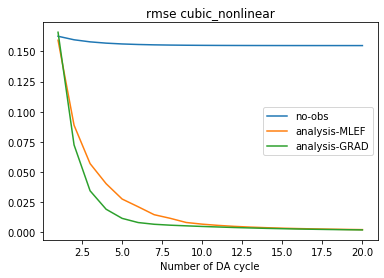

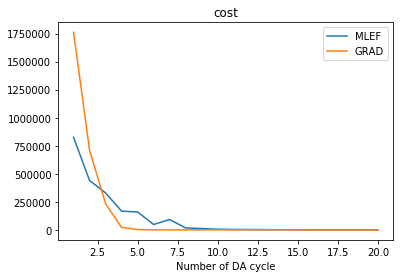

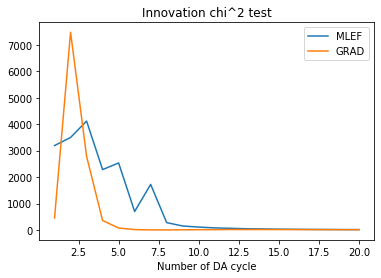

In [38]:
DAcycle = np.arange(1,N_cycles+1)
plt.plot(DAcycle,rmsen[1:],label="no-obs")
plt.plot(DAcycle,rmsea,label="analysis-MLEF")
plt.plot(DAcycle,rmseg,label="analysis-GRAD")
#plt.plot(DAcycle,rmsef,label="background")
#plt.plot(DAcycle,trPa[1:],label="trPa")
plt.xlabel("Number of DA cycle")
plt.title("rmse "+obstype[obs_opt])
plt.legend()
plt.savefig("rmse-BURGERS-mlef-grad_"+obstype[obs_opt]+".png")
plt.show()

DAcycle = np.arange(1,N_cycles+1)
plt.plot(DAcycle,Jmin_m,label="MLEF")
plt.plot(DAcycle,Jmin_g,label="GRAD")
plt.xlabel("Number of DA cycle")
plt.title("cost")
plt.legend()
plt.savefig("cost-BURGERS-mlef-grad_"+obstype[obs_opt]+".png")
plt.show()

DAcycle = np.arange(1,N_cycles+1)
plt.plot(DAcycle,Chi_m,label="MLEF")
plt.plot(DAcycle,Chi_g,label="GRAD")
plt.xlabel("Number of DA cycle")
plt.title("Innovation chi^2 test")
plt.legend()
plt.savefig("chi2-BURGERS-mlef-grad_"+obstype[obs_opt]+".png")
plt.show()

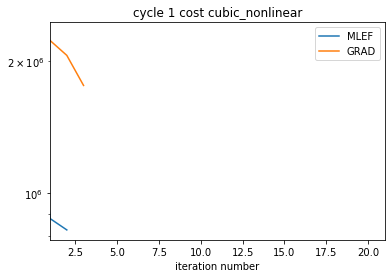

In [42]:
j_m = np.loadtxt("jh_"+obstype[obs_opt]+"_MLEF.txt")
j_g = np.loadtxt("jh_"+obstype[obs_opt]+"_GRAD.txt")
plt.plot(j_m,label="MLEF")
plt.plot(j_g,label="GRAD")
plt.yscale("log")
plt.xlim([1,21])
plt.xlabel("iteration number")
plt.title("cycle 1 cost "+obstype[obs_opt])
plt.legend()
plt.show()

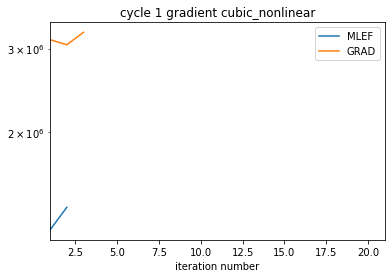

In [43]:
j_m = np.loadtxt("gh_"+obstype[obs_opt]+"_MLEF.txt")
j_g = np.loadtxt("gh_"+obstype[obs_opt]+"_GRAD.txt")
plt.plot(j_m,label="MLEF")
plt.plot(j_g,label="GRAD")
plt.yscale("log")
plt.xlim([1,21])
plt.xlabel("iteration number")
plt.title("cycle 1 gradient "+obstype[obs_opt])
plt.legend()
plt.show()

In [14]:
### assimilation
fcst_length = N_cycles * N_steps
obsmiss = jmax - N_obs
print("fcst length = {}, incr_dt = {}sec., obs miss = {}".format(fcst_length, incr_dt, obsmiss))

SPRD = []
MRMSE = []
GRMSE = []
for lag in [20,15,10,5]:
    print("lag = {}".format(lag))

## MLEF
##initialize
    init_ens(lag)
    SPRD.append(ispr)
    ua = np.zeros((fcst_length+1,jmax)) # analysis, control
    uf = np.zeros((fcst_length+1,jmax)) # forecast, control
    ue = np.zeros((jmax,mem)) # ensemble(analysis)
    uef = np.zeros((jmax,mem)) # ensemble(forecast)
    ua[0] = uc0[:]
    uf[0] = uc0[:]
    ue = ue0[:,:]
    trPa = []
    Jmin_m = []
    Chi_m = []
    P0 = sqrtPa0@sqrtPa0.T
    trPa.append(np.mean(np.diag(P0)))
    for k in range(1,fcst_length+1):
        # forecast
        uf[k] = step(ua[k-1], dx, dt, nu)
        for imem in range(mem):
            uef[:,imem] = step(ue[:,imem], dx, dt, nu)
        sqrtPf = np.zeros(uef.shape)
        sqrtPf = uef - uf[k].reshape(-1,1)#/np.sqrt(mem-1)
        #sqrtPf = (uef - uf[k].reshape(-1,1))/np.sqrt(2.0*(mem-1))
        if(k%N_steps==0):
        # analysis
            k_obs = int(k/N_steps) - 1
            print("cycle"+str(k_obs))
            mask = np.random.choice(jmax,obsmiss,replace=False)
            (ue, Pa, ua[k], jmin, chi2) = Analysis(uf[k], uef, sqrtPf, yo[k_obs], obs_s, mem, jmax, obsmiss, mask, obs_opt)
            trPa.append(np.mean(np.diag(Pa)))
            Jmin_m.append(jmin)
            Chi_m.append(chi2)
        else:
            ua[k] = uf[k]
            ue = uef[:,:]

    rmsea = np.zeros(N_cycles)
    for i in range(1,N_cycles+1):
        ind_a = i*N_steps
        ind_t = i*N_steps
        rmsea[i-1] = np.mean((ua[ind_a]-ut[ind_t])**2)
    rmsea = np.sqrt(rmsea)

    MRMSE.append(rmsea)
    
## GRAD
##initialize
    init_ens(lag)
    ua = np.zeros((fcst_length+1,jmax)) # analysis, control
    uf = np.zeros((fcst_length+1,jmax)) # forecast, control
    ue = np.zeros((jmax,mem)) # ensemble(analysis)
    uef = np.zeros((jmax,mem)) # ensemble(forecast)
    ua[0] = uc0[:]
    uf[0] = uc0[:]
    ue = ue0[:,:]
    trPa = []
    Jmin_g = []
    Chi_g = []
    P0 = sqrtPa0@sqrtPa0.T
    trPa.append(np.mean(np.diag(P0)))
    for k in range(1,fcst_length+1):
        # forecast
        uf[k] = step(ua[k-1], dx, dt, nu)
        for imem in range(mem):
            uef[:,imem] = step(ue[:,imem], dx, dt, nu)
        sqrtPf = np.zeros(uef.shape)
        sqrtPf = (uef - uf[k].reshape(-1,1))#/np.sqrt(mem-1)
        #sqrtPf = (uef - uf[k].reshape(-1,1))/np.sqrt(2.0*(mem-1))
        if(k%N_steps==0):
        # analysis
            k_obs = int(k/N_steps) - 1
            print("cycle"+str(k_obs))
            mask = np.random.choice(jmax,obsmiss,replace=False)
            (ue, Pa, ua[k], jmin, chi2) = Analysis_G(uf[k], uef, sqrtPf, yo[k_obs], obs_s, mem, jmax, obsmiss, mask, obs_opt)
            trPa.append(np.mean(np.diag(Pa)))
            Jmin_g.append(jmin)
            Chi_g.append(chi2)
        else:
            ua[k] = uf[k]
            ue = uef[:,:]
    rmseg = np.zeros(N_cycles)
    for i in range(1,N_cycles+1):
        ind_a = i*N_steps
        ind_t = i*N_steps
        rmseg[i-1] = np.mean((ua[ind_a]-ut[ind_t])**2)
    rmseg = np.sqrt(rmseg)

    GRMSE.append(rmseg)
    
print(MRMSE)
print(GRMSE)
#print("error covariance")
#print(trPa)

fcst length = 400, incr_dt = 900.0sec., obs miss = 0
lag = 20
initial ensemble spread = 0.039251759990821804
ensemble initialized
cycle0
4.9e-07
70.41254401546396
         Current function value: 1648542.305841
         Iterations: 3
         Function evaluations: 111
         Gradient evaluations: 99
cycle1
4.9e-07
10273.177146617569
         Current function value: 615110.913319
         Iterations: 7
         Function evaluations: 51
         Gradient evaluations: 40
cycle2
4.9e-07
91794.00141690233
         Current function value: 293553.176436
         Iterations: 6
         Function evaluations: 52
         Gradient evaluations: 40
cycle3
4.9e-07
778232.3289179038
         Current function value: 67593.239294
         Iterations: 6
         Function evaluations: 65
         Gradient evaluations: 53
cycle4
4.9e-07
4235684.045405557
Optimization terminated successfully.
         Current function value: 19376.254047
         Iterations: 10
         Function evaluations: 13
         

cycle19
4.9e-07
104855089352.90665
Optimization terminated successfully.
         Current function value: 10720.826583
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
lag = 15
initial ensemble spread = 0.022794892700595613
ensemble initialized
cycle0
4.9e-07
53.568038029141384
         Current function value: 1815138.121424
         Iterations: 3
         Function evaluations: 71
         Gradient evaluations: 59
cycle1
4.9e-07
124018.62392458058
         Current function value: 852947.794986
         Iterations: 7
         Function evaluations: 57
         Gradient evaluations: 45
cycle2
4.9e-07
1591130.2717572434
Optimization terminated successfully.
         Current function value: 362202.299460
         Iterations: 7
         Function evaluations: 11
         Gradient evaluations: 11
cycle3
4.9e-07
14448769.179301653
         Current function value: 74132.617493
         Iterations: 4
         Function evaluations: 61
         Gradient evalu

244669092163.15714
Optimization terminated successfully.
         Current function value: 4855.774168
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
cycle19
4.9e-07
318063186677.0638
Optimization terminated successfully.
         Current function value: 4231.338950
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
lag = 10
initial ensemble spread = 0.01038567344451425
ensemble initialized
cycle0
4.9e-07
125.5006711823505
         Current function value: 826461.279362
         Iterations: 3
         Function evaluations: 74
         Gradient evaluations: 62
cycle1
4.9e-07
1046495.4666124441
         Current function value: 439584.015206
         Iterations: 11
         Function evaluations: 60
         Gradient evaluations: 48
cycle2
4.9e-07
9020551.019949744
Optimization terminated successfully.
         Current function value: 330675.760781
         Iterations: 7
         Function evaluations: 11
        

         Current function value: 608.904792
         Iterations: 4
         Function evaluations: 85
         Gradient evaluations: 71
cycle18
4.9e-07
185279727045.0222
         Current function value: 595.154840
         Iterations: 4
         Function evaluations: 103
         Gradient evaluations: 89
cycle19
4.9e-07
297942597531.53033
Optimization terminated successfully.
         Current function value: 493.029555
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
lag = 5
initial ensemble spread = 0.002637685023391275
ensemble initialized
cycle0
4.9e-07
205.27734113924754
         Current function value: 938512.141019
         Iterations: 4
         Function evaluations: 74
         Gradient evaluations: 62
cycle1
4.9e-07
19054799.768793806
         Current function value: 758679.535529
         Iterations: 7
         Function evaluations: 59
         Gradient evaluations: 47
cycle2
4.9e-07
160228128.7395594
         Current function value: 834

         Current function value: 35480.840924
         Iterations: 3
         Function evaluations: 39
         Gradient evaluations: 27
cycle19
4.9e-07
1339230563688.9055
         Current function value: 94251.823463
         Iterations: 5
         Function evaluations: 81
         Gradient evaluations: 69
[array([0.14803429, 0.06722614, 0.03653936, 0.02272035, 0.01642751,
       0.01338393, 0.01135407, 0.0097897 , 0.00851245, 0.00746089,
       0.00660604, 0.00590783, 0.00529004, 0.00479209, 0.00436923,
       0.00400959, 0.00370178, 0.00342686, 0.00319507, 0.00298491]), array([0.1300482 , 0.06431772, 0.03764638, 0.02544395, 0.01964576,
       0.01615906, 0.01357448, 0.01377077, 0.01180953, 0.01179724,
       0.01033616, 0.01032014, 0.00919803, 0.00920744, 0.00836213,
       0.00840552, 0.00773956, 0.00715978, 0.00666545, 0.00622758]), array([0.15908101, 0.08872859, 0.05694301, 0.04026802, 0.02752458,
       0.02114001, 0.01458569, 0.01162546, 0.00819967, 0.00684985,
       0.0058269

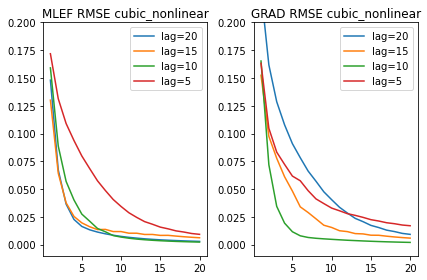

In [15]:
DAcycle = np.arange(1,N_cycles+1)
Lag = [20,15,10,5]
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1,title="MLEF RMSE "+obstype[obs_opt])
for i in range(len(Lag)):
    ax1.plot(DAcycle,MRMSE[i],label="lag="+str(Lag[i]))
plt.ylim([-0.01,0.2])
plt.legend()

ax2 = fig.add_subplot(1,2,2,title="GRAD RMSE "+obstype[obs_opt])
for i in range(len(Lag)):
    ax2.plot(DAcycle,GRMSE[i],label="lag="+str(Lag[i]))
plt.legend()
plt.ylim([-0.01,0.2])
fig.tight_layout()
plt.savefig("lag-RMSE_"+obstype[obs_opt]+".png")
plt.show()

[0.01928661 0.02139174 0.0235766  0.05006014]
[0.05958575 0.03221603 0.01818288 0.04645096]


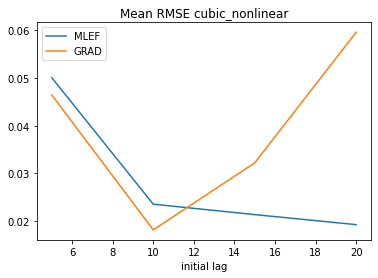

In [16]:
data = np.array(MRMSE)
rmse_m = np.mean(data,axis=1)
print(rmse_m)
data = np.array(GRMSE)
rmse_g = np.mean(data,axis=1)
print(rmse_g)
plt.plot(Lag,rmse_m,label="MLEF")
plt.plot(Lag,rmse_g,label="GRAD")
#plt.xscale('log')
#plt.xlabel('initial spread')
plt.xlabel('initial lag')
plt.legend()
plt.title('Mean RMSE '+obstype[obs_opt])
plt.savefig("lag-meanRMSE_"+obstype[obs_opt]+".png")
plt.show()